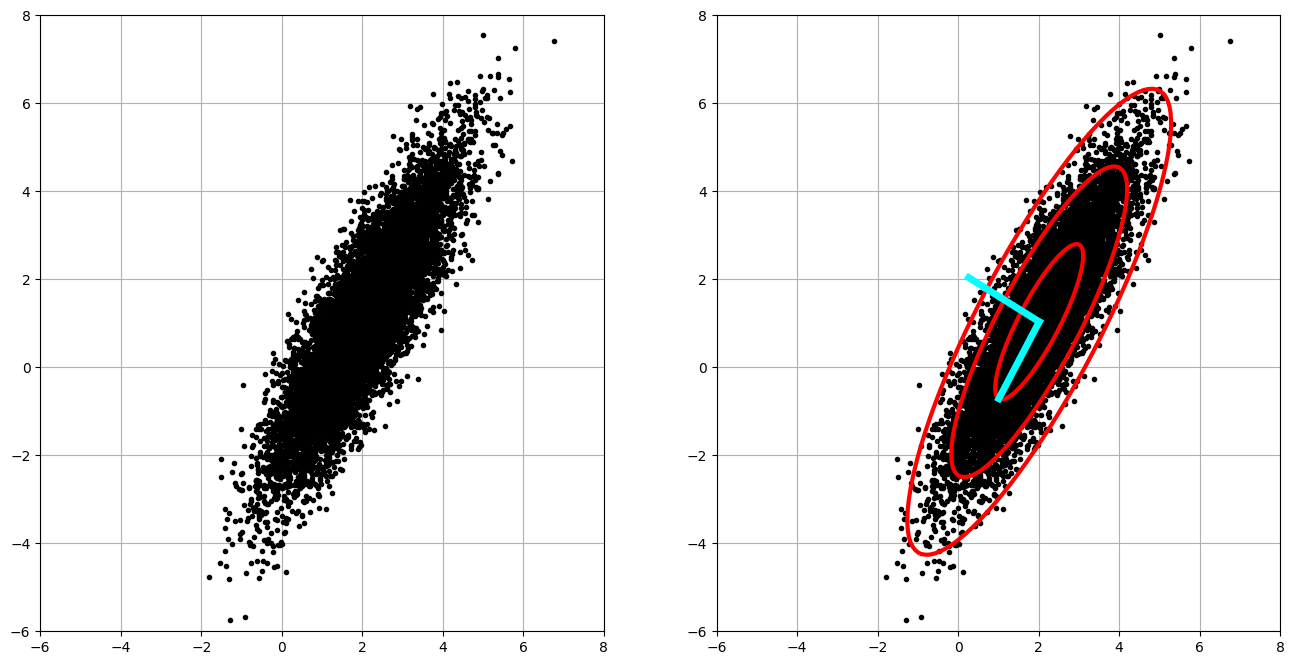

In [6]:
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams['figure.figsize'] = [16, 8]

xC = np.array([2, 1]) #Center of data (mean)
sig = np.array([2, 0.5]) #Principal axes

theta = np.pi/3 #Rotate cloud by pi/3

R = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]]) #Rotation matrix

nPoints = 10000 #Create 10 points
X = R @ np.diag(sig) @ np.random.randn(2, nPoints) + np.diag(xC) @ np.ones((2, nPoints)) 

fig = plt.figure()
ax1 = fig.add_subplot(121)
ax1.plot(X[0,:],X[1,:],'k.')
ax1.grid()
plt.xlim((-6,8))
plt.ylim((-6,8))

Xavg = np.mean(X,axis=1) #Compute mean
#X = B - np.tile(Xavg, (nPoints, 1)).T #Mean-subtracted data

H = np.eye(nPoints)-1/nPoints*np.ones((nPoints,nPoints)) #Centering matrix
B = X@H #Mean-centered data

#Find principal components (SVD)
U, S, VT = np.linalg.svd(B/np.sqrt(nPoints-1), full_matrices=0)

ax2 = fig.add_subplot(122)
ax2.plot(X[0,:],X[1,:],'k.')
ax2.grid()
plt.xlim((-6,8))
plt.ylim((-6,8))

theta = 2 * np.pi * np.arange(0,1,0.01)

#1-std confidence interval
Xstd = U @ np.diag(S) @ np.array([np.cos(theta), np.sin(theta)])

ax2.plot(Xavg[0] + Xstd[0,:], Xavg[1] + Xstd[1,:],'-',color='r',linewidth=3)
ax2.plot(Xavg[0] + 2*Xstd[0,:], Xavg[1] + 2*Xstd[1,:],'-',color='r',linewidth=3)
ax2.plot(Xavg[0] + 3*Xstd[0,:], Xavg[1] + 3*Xstd[1,:],'-',color='r',linewidth=3)

#Plot principal components U[:,0]S[0] and U[:,1]S[1]
ax2.plot(np.array([Xavg[0], Xavg[0]+U[0,0]*S[0]]), np.array([Xavg[1], Xavg[1]+U[1,0]*S[0]]), '-', color='cyan', linewidth=5)
ax2.plot(np.array([Xavg[0], Xavg[0]+U[0,1]*S[0]]), np.array([Xavg[1], Xavg[1]+U[1,1]*S[0]]), '-', color='cyan', linewidth=5)

<h1>Optimal threshold</h1>

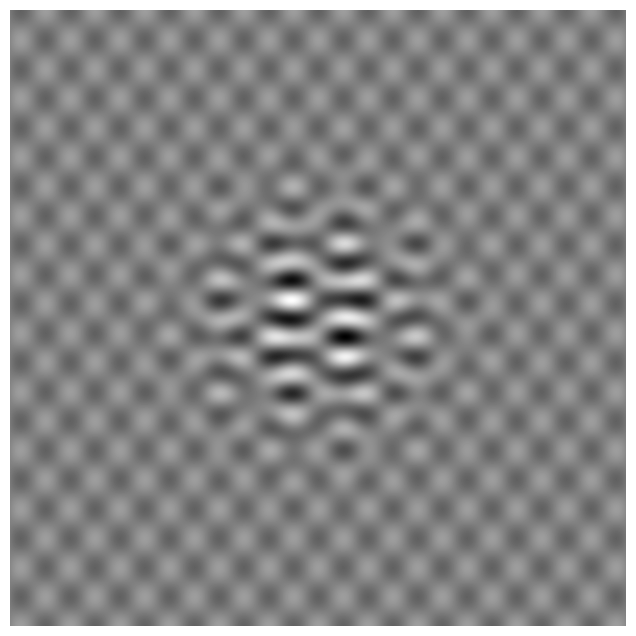

In [9]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
plt.rcParams['figure.figsize'] = [8,8]
plt.rcParams.update({'font.size': 18})

t = np.arange(-3,3,0.01)

Utrue = np.array([np.cos(17*t) * np.exp(-t**2), np.sin(11*t)]).T
Strue = np.array([[2,0],[0,0.5]])
Vtrue = np.array([np.sin(5*t) * np.exp(-t**2), np.cos(13*t)]).T

X = Utrue @ Strue @ Vtrue.T

plt.imshow(X)
plt.set_cmap('gray')
plt.axis('off')
plt.show()

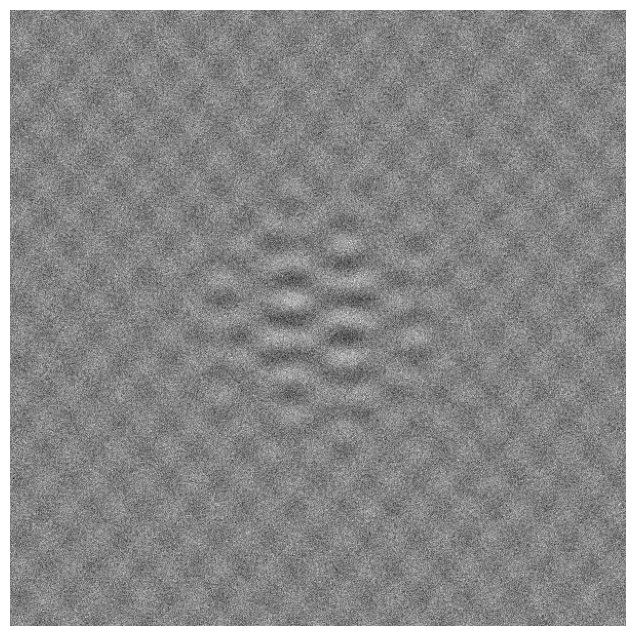

In [10]:
sigma = 1
Xnoisy = X + sigma*np.random.randn(X.shape[0],X.shape[1])
plt.imshow(Xnoisy)
plt.set_cmap('gray')
plt.axis('off')
plt.show()

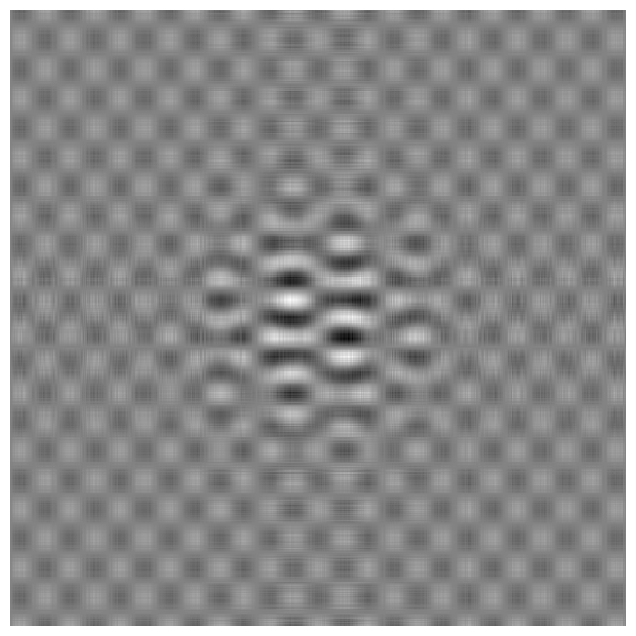

In [13]:
U, S, VT = np.linalg.svd(Xnoisy, full_matrices=0)
N = Xnoisy.shape[0]
cutoff = (4/np.sqrt(3)) * np.sqrt(N) * sigma #Hard threshold
r = np.max(np.where(S > cutoff)) #Keep modes w/ sig > cutoff

Xclean = U[:,:(r+1)] @ np.diag(S[:(r+1)]) @ VT[:(r+1),:]
plt.imshow(Xclean)
plt.set_cmap('gray')
plt.axis('off')
plt.show()

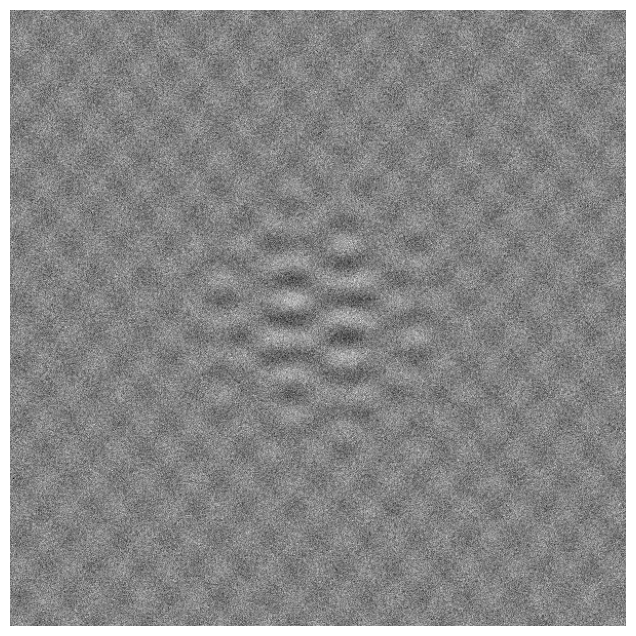

In [14]:
cdS = np.cumsum(S) / np.sum(S) #Cumulative energy
r90 = np.min(np.where(cdS > 0.90)) #Find r to capture 90% energy

X90 = U[:,:(r90+1)] @ np.diag(S[:(r90+1)]) @ VT[:(r90+1),:]
plt.imshow(X90)
plt.set_cmap('gray')
plt.axis('off')
plt.show()

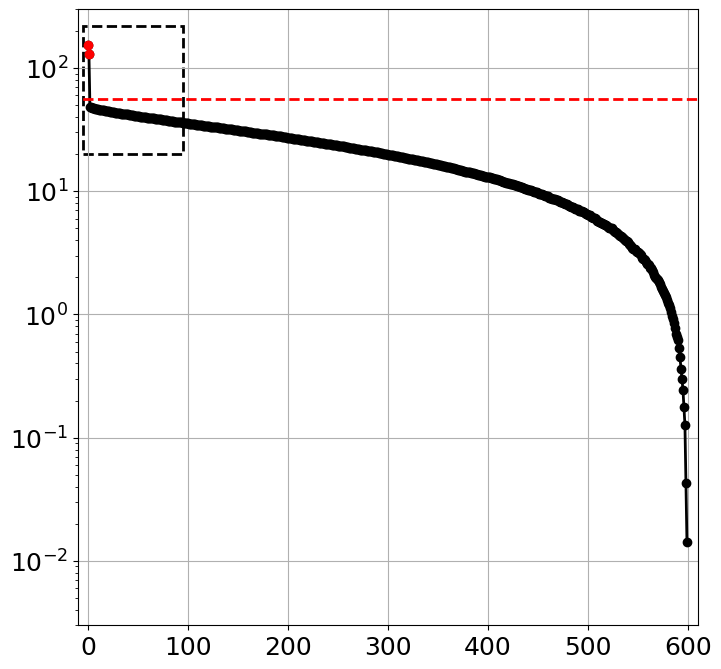

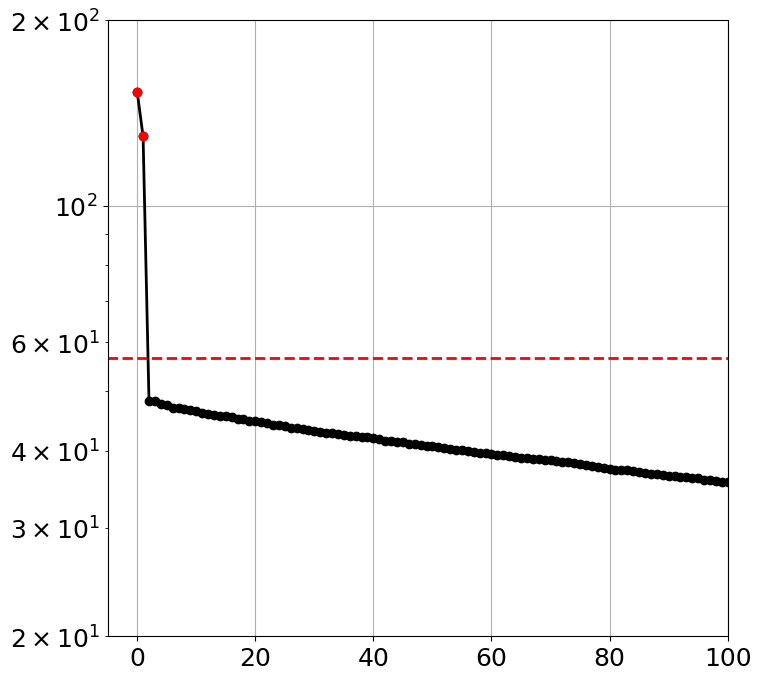

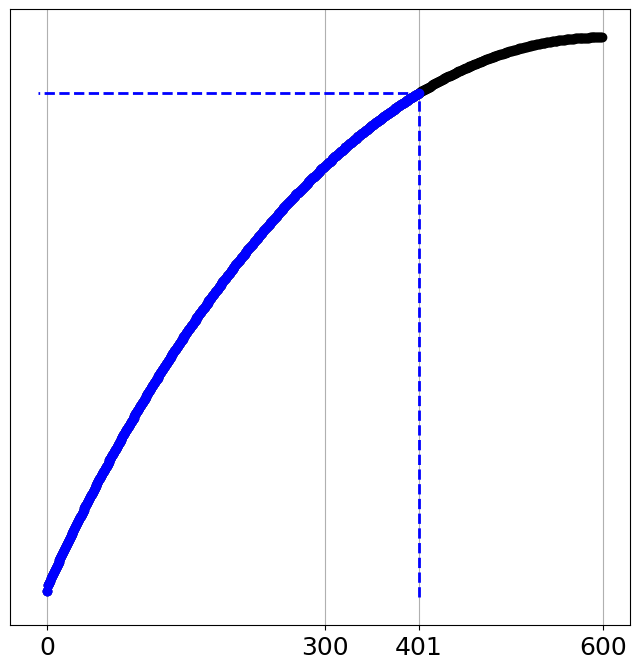

In [20]:
#Plot singular values
fig1, ax1 = plt.subplots(1)

ax1.semilogy(S, '-o', color='k', linewidth=2)
ax1.semilogy(np.diag(S[:(r+1)]), 'o', color='r', linewidth=2)
ax1.plot(np.array([-20, N+20]), np.array([cutoff, cutoff]), '--', color='r', linewidth=2)
rect = patches.Rectangle((-5, 20), 100, 200, linewidth=2, linestyle='--', edgecolor='k', facecolor='none')
ax1.add_patch(rect)
plt.xlim((-10, 610))
plt.ylim((0.003, 300))
ax1.grid()
plt.show()

fig2, ax2 = plt.subplots(1)
ax2.semilogy(S, '-o', color='k', linewidth=2)
ax2.semilogy(np.diag(S[:(r+1)]), 'o', color='r', linewidth=2)
ax2.plot(np.array([-20, N+20]), np.array([cutoff, cutoff]), '--', color='r', linewidth=2)
plt.xlim((-5, 100))
plt.ylim((20, 200))
ax2.grid()
plt.show()

fig3, ax3 = plt.subplots(1)
ax3.plot(cdS, '-o', color='k', linewidth=2)
ax3.plot(cdS[:(r90+1)], 'o', color='b', linewidth=2)
ax3.plot(cdS[:(r+1)], 'o', color='b', linewidth=2)
plt.xticks(np.array([0, 300, r90, 600]))
plt.yticks(np.array([-10, 610]))
ax3.plot(np.array([r90, r90, -10]), np.array([0, 0.9, 0.9]), '--', color='b', linewidth=2)
ax3.grid()
plt.show()

In [22]:
print(cutoff)

56.56854249492381


<h1>Rotating image</h1>

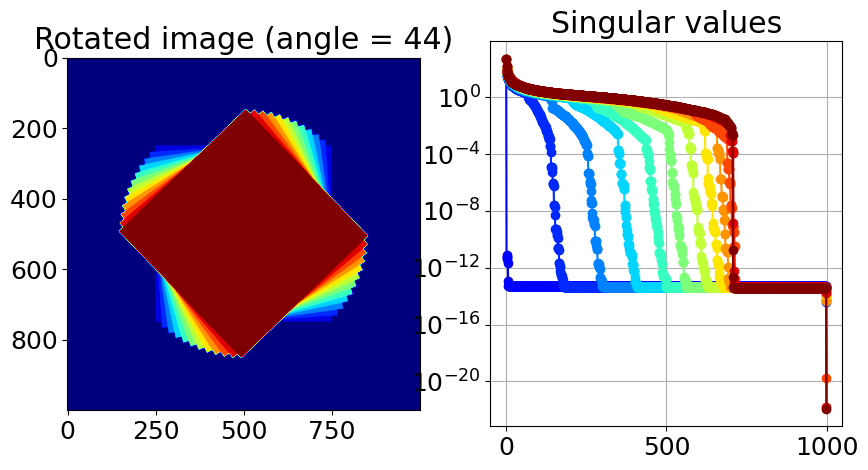

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import svd
from scipy.ndimage import rotate

from IPython import display
from time import sleep

#Initial parameters
n = 1000
X = np.zeros((n,n))
X[n//4:3*n//4, n//4:3*n//4] = 1

#Calculate SVD
U, S, VT = svd(X)

#View image X
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(X, cmap='gray')
plt.title('Original image')

#View singular values
plt.subplot(1, 2, 2)
plt.semilogy(S, '-o', color='blue')
plt.title('Singular values')
plt.grid(True)

#Rotation parameters
nAngles = 12 #Sweep through 12 angles, from 0:4:44
Xrot = X.copy()

#Sweep through angles
for i in range(2, nAngles+1):
    angle = (i-1)*4 #Rotate by 4 degrees

    Y = rotate(X, angle, reshape=True, order=3) #Rotate image

    startind = (Y.shape[0] - n) // 2 #Center crop
    Xrot1 = Y[startind:startind+n, startind:startind+n] #Crop image to 1000x1000

    #Normalization
    Xrot2 = Xrot1 - Xrot1[0,0]
    Xrot2 = Xrot2 / np.max(Xrot2)

    Xrot[Xrot2 > 0.5] = i #Update image

    #Calculate SVD of rotated image
    U, S, VT = svd(Xrot1)

    #View rotated image
    plt.subplot(1, 2, 1)
    plt.imshow(Xrot, cmap='jet')
    plt.title('Rotated image (angle = %d)' % angle)

    plt.subplot(1, 2, 2) #View singular values
    plt.semilogy(S, '-o', color=plt.cm.jet(i/nAngles)) #Plot singular values
    plt.title('Singular values')
    plt.grid(True)

plt.show()


<h1>rSVD</h1>

In [26]:
import numpy as np

A = np.array([[1, 3, 2],
              [5, 3, 1],
              [3, 4, 5]])
u, s, v = np.linalg.svd(A, full_matrices=0)
print('Left singular vectors: ')
print(u)
print()
print('Singular values: ')
print(s)
print()
print('Right singular vectors: ')
print(v)
print()

Left singular vectors: 
[[-0.37421754  0.28475648 -0.88253894]
 [-0.56470638 -0.82485997 -0.02669705]
 [-0.7355732   0.48838486  0.46948087]]

Singular values: 
[9.34265841 3.24497827 1.08850813]

Right singular vectors: 
[[-0.57847229 -0.61642675 -0.53421706]
 [-0.73171177  0.10269066  0.67383419]
 [ 0.36051032 -0.78068732  0.51045041]]



In [27]:
import numpy as np

def rsvd(A, Omega):
    Y = A @ Omega
    Q, _ = np.linalg.qr(Y)
    B = Q.T @ A
    u_tilde, s, v = np.linalg.svd(B, full_matrices=0)
    u = Q @ u_tilde
    return u, s, v

In [28]:
np.random.seed(1000)

A = np.array([[1, 3, 2],
              [5, 3, 1],
              [3, 4, 5]])

rank = 2
Omega = np.random.randn(A.shape[1], rank)
u, s, v = rsvd(A, Omega)

print('Left singular vectors: ')
print(u)
print()
print('Singular values: ')
print(s)
print()
print('Right singular vectors: ')
print(v)
print()

Left singular vectors: 
[[ 0.38070859  0.60505354]
 [ 0.56830191 -0.74963644]
 [ 0.72944767  0.26824507]]

Singular values: 
[9.34224023 3.02039888]

Right singular vectors: 
[[ 0.57915029  0.61707064  0.53273704]
 [-0.77420021  0.21163814  0.59650929]]



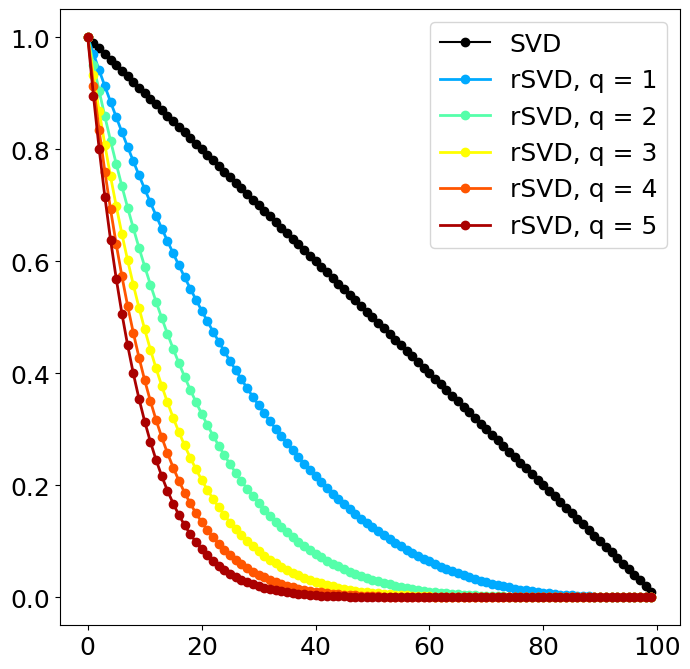

In [31]:
import numpy as np
import matplotlib.pyplot as plt

#Illustrate power iteration
X = np.random.randn(1000, 100)
U, S, VT = np.linalg.svd(X, full_matrices=0)
S = np.arange(1, 0, -0.01)
X = U @ np.diag(S) @ VT

color_list = np.array([[0,0,2/3],
                      [0,0,1],
                      [0,1/3,1],
                      [0,2/3,1],
                      [0,1,1],
                      [1/3,1,2/3],
                      [2/3,1,1/3],
                      [1,1,0],
                      [1,2/3,0],
                      [1,1/3,0],
                      [1,0,0],
                      [2/3,0,0]])

plt.plot(S, '-o', color='k', label='SVD')

Y = X
for q in range(1,6):
    Y = X.T @ Y
    Y = X @ Y
    Uq, Sq, VTq = np.linalg.svd(Y, full_matrices=0)
    plt.plot(Sq, '-o', color=tuple(color_list[2*q+1]), linewidth=2, label='rSVD, q = ' + str(q))

plt.legend()
plt.show()

In [32]:
def power_iteration(A, Omega, power_iter = 3):
    Y = A @ Omega
    for q in range(power_iter):
        Y = A @ (A.T @ Y)
    Q, _ = np.linalg.qr(Y)
    return Q

def rsvd(A, Omega):
    Q = power_iteration(A, Omega)
    B = Q.T @ A
    u_tilde, s, v = np.linalg.svd(B, full_matrices=0)
    u = Q @ u_tilde
    return u, s, v

<h1>rSVD Lena</h1>

In [39]:
import matplotlib.pyplot as plt
from matplotlib.image import imread
import numpy as np
import os

plt.rcParams['figure.figsize'] = [16, 6]
plt.rcParams.update({'font.size': 18})

#Define randomized SVD function
def rSVD(A, k, q, p):
    #Step 1: Sample column space of A with Omega matrix
    ny = A.shape[1]
    Omega = np.random.randn(ny, k + p)
    Y = A @ Omega
    for j in range(q):
        Y = A @ (A.T @ Y)

    Q, R = np.linalg.qr(Y, mode='reduced')

    #Step 2: Compute SVD on projected B = Q.T @ A
    B = Q.T @ A
    Ut, S, VT = np.linalg.svd(B, full_matrices=0)
    U = Q @ Ut

    return U, S, VT

In [35]:
!pwd

/Users/fabrizio/Desktop/NAML - Numerical Analysis for Machine Learning/Jupyter Notebooks/24:25


In [41]:
A = imread(os.path.join('.', 'Lena.png'))
A = np.mean(A, axis=2) #Convert RGB to grayscale

%time U, S, VT = np.linalg.svd(A, full_matrices=0) #Deterministic SVD

CPU times: user 30.7 ms, sys: 4.24 ms, total: 34.9 ms
Wall time: 37.1 ms


In [42]:
r = 50 #Target rank
q = 1 #Power iterations
p = 5 #Oversampling parameter

%time rU, rS, rVT = rSVD(A, r, q, p) #rSVD

CPU times: user 6.88 ms, sys: 8.72 ms, total: 15.6 ms
Wall time: 18.4 ms


In [43]:
#Reconstruction
ASVD = U[:, :(r+1)] @ np.diag(S[:(r+1)]) @ VT[:(r+1), :] #SVD approximation
err_SVD = np.linalg.norm(A - ASVD, ord=2) #SVD error

ArSVD = rU[:, :(r+1)] @ np.diag(rS[:(r+1)]) @ rVT[:(r+1), :] #rSVD approximation
err_rSVD = np.linalg.norm(A - ArSVD, ord=2) / np.linalg.norm(A, ord=2) #rSVD error
print(err_SVD, err_rSVD)

2.4649363 0.011041254349718008


In [44]:
S[r+1]/np.linalg.norm(A, ord=2)

np.float32(0.009439635)

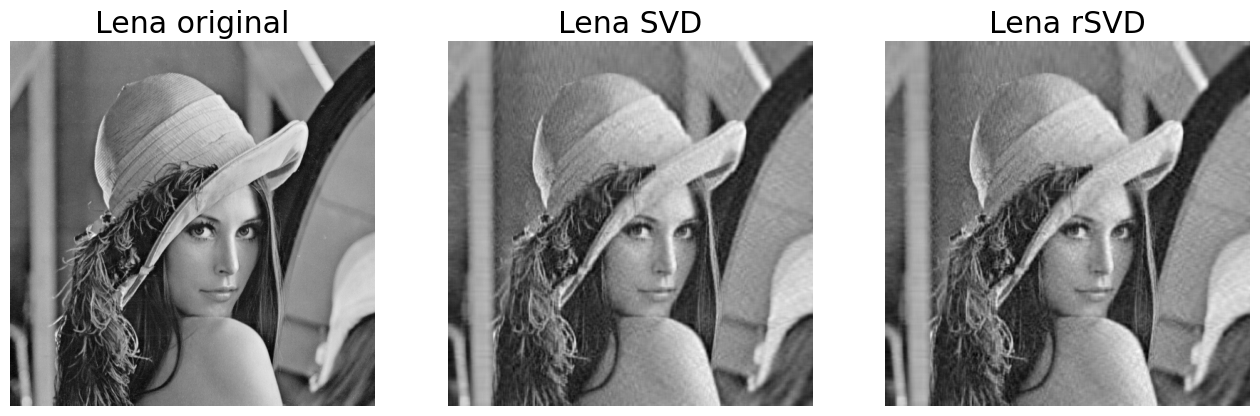

In [45]:
#Plot
fig, axs = plt.subplots(1, 3)

plt.set_cmap('gray')
axs[0].imshow(A)
axs[0].axis('off')
axs[0].set_title('Lena original')
axs[1].imshow(ASVD)
axs[1].axis('off')
axs[1].set_title('Lena SVD')
axs[2].imshow(ArSVD)
axs[2].axis('off')
axs[2].set_title('Lena rSVD')

plt.show()